<a href="https://colab.research.google.com/github/then00bprogrammer/Deep-Learning-Projects-and-Experiments/blob/main/Transfer_Learning_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfer Learning Part 2: Fine-Tuning
In the previous notebook, we covered Transfer Learning feature extraction, now it's time to learn about a new kind of transfer learning: fine-tuning

In [ ]:
#Check if we're using a GPU
!nvidia-smi

Thu Sep 29 11:48:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Creating helper functions
In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however, that is tedious.

So it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks or elsewhere.

We've done this for some of the functions we've used previously here: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-09-28 12:25:13--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-09-28 12:25:13 (48.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
#Import helper functions we're going to use in this noteboook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

> 🔑 **Note:** If you're running this notebook in Google Colab. when it times out Colab will delete `helper_functions.py`, so you'll have to redownload it if you want to access your helper functions.

##Let's get some data

This time we're going to see how we can use pretrained models within `tf.keras.applications` and apply them to our problem (recongnizing images of food).

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2022-09-28 12:25:16--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.69.128, 64.233.183.128, 173.194.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   186MB/s    in 0.9s    

2022-09-28 12:25:17 (186 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
#Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [ ]:
#Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
import tensorflow as tf
IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir,
    image_size=IMG_SIZE,
    label_mode="categorical",
    batch_size=BATCH_SIZE
)

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_dir,
    image_size=IMG_SIZE,
    label_mode="categorical",
    batch_size=BATCH_SIZE
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
#Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

##Model 0: Building a transfer learning model using Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with out models.

In [ ]:
#1. Create base model with tf.keras.applications

base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)

#Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable=False

#3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=IMG_SIZE+(3,),name="input_layer")
 
#4. If using Resnet50V2 you will need to normalize inputs
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

#5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

#6. Average pool  the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="gloabl_average_pooling_layer")(x)
print(f"Shape after GloablAveragePooling2D: {x.shape}")

#7. Create the output activaiton layer
outputs = tf.keras.layers.Dense(10,activation="softmax",name="output_layer")(x)

#8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs,outputs)

#9. Compile the model
model_0.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)
#10. Fit the model and save its history
history_0=model_0.fit(train_data_10_percent,
                      epochs=5,
                      steps_per_epoch=len(train_data_10_percent),
                      validation_data=test_data_10_percent,
                      validation_steps=int(0.25*len(test_data_10_percent)),
                      callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                             experiment_name="10_percent_feature_extraction")])


16719872/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GloablAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20220928-122524
Epoch 1/5
24/24 [==============================] - 115s 4s/step - loss: 1.9694 - accuracy: 0.4000 - val_loss: 1.3574 - val_accuracy: 0.7122
Epoch 2/5
24/24 [==============================] - 93s 4s/step - loss: 1.1797 - accuracy: 0.7480 - val_loss: 0.9133 - val_accuracy: 0.8174
Epoch 3/5
24/24 [==============================] - 101s 4s/step - loss: 0.8699 - accuracy: 0.8000 - val_loss: 0.7302 - val_accuracy: 0.8438
Epoch 4/5
24/24 [==============================] - 98s 4s/step - loss: 0.6916 - accuracy: 0.8440 - val_loss: 0.6351 - val_accuracy: 0.8520
Epoch 5/5
24/24 [==============================] - 138s 6s/step - loss: 0.5972 - accuracy: 0.8653 - val_loss: 0.5728 - val_accuracy: 0.8618


In [ ]:
#Evaluate on the full test dataset
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 161s 2s/step - loss: 0.6026 - accuracy: 0.8424


[0.6025769114494324, 0.8424000144004822]

In [ ]:
#Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [ ]:
#How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [ ]:
# How about a summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 gloabl_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


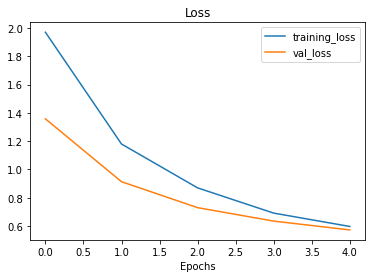

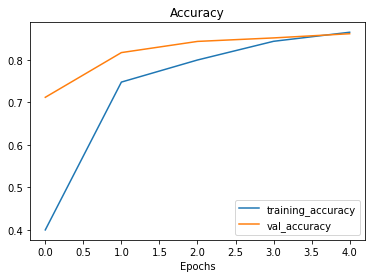

In [ ]:
#Check out our model's training curves:
plot_loss_curves(history_0)

##Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None,7,7,1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None,1280).

Let's use a similar shaped tensor of (1,4,4,3) and then pass it to GlobalAveragePooling2D.

In [ ]:
#Define the input shape
input_shape = (1,4,4,3)

#Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input Tensor:\n {input_tensor}\n")

#Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled tensor:\n {global_average_pooled_tensor}")

#Check the shape of the different tesnors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global tensor: {global_average_pooled_tensor.shape}")

Random input Tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]

2D global average pooled tensor:
 [[-0.09368646 -0.45840445 -0.28855976]]
Shape of input tensor: (1, 4, 4, 3)
Shape of Global tensor: (1, 3)


In [ ]:
#Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor,axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>

>⚒ **Practice:** Try to do same with above 2 cells but this time use `GlobalMaxPool2D` ... and see what happens.

In [ ]:
global_max_pooled_tensor = tf.keras.layers.GlobalMaxPooling2D()(input_tensor)
print(f"Random Input tensor: {input_tensor}")
print(f"Max Pooled tensor: {global_max_pooled_tensor}")
global_max_pooled_tensor.shape

Random Input tensor: [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]
Max Pooled tensor: [[0.9058464 1.1603122 1.6994323]]


TensorShape([1, 3])

##Running a series of Transfer Learning experiments

We've seen the incredible results transfer learning can get with 10%, let's find out how it performs on 1%

1. `model-1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model-2` - use feature extraction T.L. with 10% of the training with data augmentation.
3. `model-3` - use fine-tuning T.L. on 10% of the training data with data augmentation
4. `model-4` - use fine tuning T.L. on 100% of the training data with data augmentation

> 🔑**Note**: throughout all experiments the same test dataset will be used to evaluate our model...this ensures consistency across evaluation metrics.

##Getting and preprocessing data for model_1

In [ ]:
#Download and unzip data - preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data('10_food_classes_1_percent.zip')

--2022-09-28 12:37:59--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.121.128, 108.177.120.128, 142.250.159.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.121.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   212MB/s    in 0.6s    

2022-09-28 12:38:00 (212 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
#Create training and test dirs
train_dir_1_percent='10_food_classes_1_percent/train'
test_dir='10_food_classes_1_percent/test'

In [ ]:
#How many images are we working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'

In [ ]:
#Setup Data loaders
IMG_SIZE = (224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_1_percent,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE #default=32
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE #default=32
)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


##Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside
* `tf.keras.experimental.preprocessing()`

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

#Create data augmentation stage with horizontal flipping, rotations, zooms, etc

data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescale(1./255) #Keep for models like ResNet50V2 but EfficentNet's have rescaling built right in
],name="data_augmentation")

###Visualizing Data Augmentation

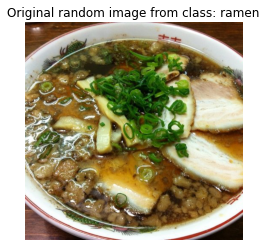

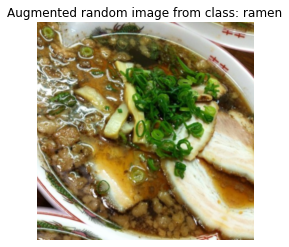

In [ ]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0),training=True) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

##Model 1: Feature Extraction Transfer learning on 1% of the data with data augmentation

In [ ]:
#Setup input shape and base model, freezing the base model layers
input_shape = (224,224,3)
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable=False

#Create input layer
inputs = layers.Input(shape=input_shape,name="input_layer")

#Add in data augmentation Sequential model as a layer
x= data_augmentation(inputs)

#Give base model the inputs (after augmentation) and don't train it
x=base_model(x,training=False)

#Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

#Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax",name="output_layer")(x)

#Make a model using inputs and outputs
model_1 = keras.Model(inputs,outputs)

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

#Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25*len(test_data)),
                                #Track model training logs
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data_aug")])


Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20220928-123805
Epoch 1/5
3/3 [==============================] - 55s 23s/step - loss: 2.4583 - accuracy: 0.0571 - val_loss: 2.2265 - val_accuracy: 0.1924
Epoch 2/5
3/3 [==============================] - 45s 21s/step - loss: 2.1332 - accuracy: 0.2429 - val_loss: 2.1253 - val_accuracy: 0.2549
Epoch 3/5
3/3 [==============================] - 45s 22s/step - loss: 1.9560 - accuracy: 0.4286 - val_loss: 2.0179 - val_accuracy: 0.3405
Epoch 4/5
3/3 [==============================] - 45s 22s/step - loss: 1.8035 - accuracy: 0.5571 - val_loss: 1.8997 - val_accuracy: 0.4309
Epoch 5/5
3/3 [==============================] - 88s 43s/step - loss: 1.6255 - accuracy: 0.7286 - val_loss: 1.8083 - val_accuracy: 0.5033


In [ ]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
#Evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 190s 2s/step - loss: 1.8044 - accuracy: 0.4724


[1.8043687343597412, 0.4724000096321106]

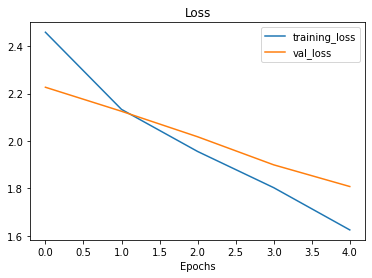

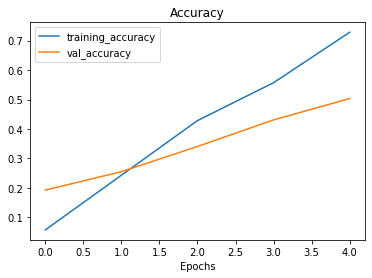

In [ ]:
#How does loss curves look with 1% of the data?
plot_loss_curves(history_1_percent)

##Model 2: Transfer Learning with 10% of the data and data augmentation

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

--2022-09-28 12:48:51--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.1.128, 108.177.121.128, 108.177.120.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.1.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   124MB/s    in 1.3s    

2022-09-28 12:48:52 (124 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [ ]:
#Set up training and testing directories
train_dir ="10_food_classes_10_percent/train"
test_dir="10_food_classes_10_percent/test"

In [ ]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [ ]:
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)
test_data= tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
#Setup input shape and base model, freezing the base model layers
input_shape = (224,224,3)
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable=False

#Create input layer
inputs = layers.Input(shape=input_shape,name="input_layer")

#Add in data augmentation Sequential model as a layer
x= data_augmentation(inputs)

#Give base model the inputs (after augmentation) and don't train it
x=base_model(x,training=False)

#Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

#Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax",name="output_layer")(x)

#Make a model using inputs and outputs
model_2 = keras.Model(inputs,outputs)

model_2.compile(loss="categorical_crossentropy",
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

# history_10_percent_data_aug=model_2.fit(train_data_10_percent,
#             epochs=5,
#             steps_per_epoch=len(train_data_10_percent),
#             validation_steps=int(0.25*len(test_data)),
#             validation_data=test_data,
#             callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
#                                                    experiment_name="10_percent_data_aug")])

In [ ]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

###Creating a ModelCheckpoint Callback

The ModelCheckpoint callback imtermediately saves our model(the full model or just the weights) during the training. This is useful so we can come and start where we left off.

In [ ]:
#Set Checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

#Create a ModelCheckpoint callback that saves model's weigths only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch", #save every epoch
                                                         verbose=1)

In [ ]:
history_10_percent_data_aug=model_2.fit(train_data_10_percent,
                epochs=5,
                steps_per_epoch=len(train_data_10_percent),
                validation_steps=int(0.25*len(test_data)),
                validation_data=test_data,
                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                       experiment_name="10_percent_data_aug"),
                           checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220928-124900
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0271 - accuracy: 0.3293
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 144s 6s/step - loss: 2.0271 - accuracy: 0.3293 - val_loss: 1.4982 - val_accuracy: 0.6612
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3663 - accuracy: 0.6640
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 104s 4s/step - loss: 1.3663 - accuracy: 0.6640 - val_loss: 1.0694 - val_accuracy: 0.7664
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0624 - accuracy: 0.7533
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 102s 4s/step - loss: 1.0624 - accuracy: 0.7533 - val_loss: 0.8508 - val_accuracy: 0.8059
Epoch 4

In [ ]:
model_0.evaluate(test_data)

79/79 [==============================] - 162s 2s/step - loss: 0.6026 - accuracy: 0.8424


[0.6025770902633667, 0.8424000144004822]

In [ ]:
results_10_percent_data_aug=model_2.evaluate(test_data)

79/79 [==============================] - 161s 2s/step - loss: 0.6943 - accuracy: 0.8112


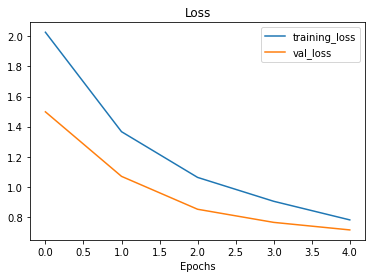

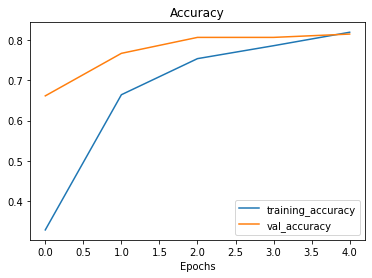

In [ ]:
plot_loss_curves(history_10_percent_data_aug)

###Loading in checkpointed weights
Loading in checkpointed weights and evaluate model to a specific checkpoint.

In [ ]:
model_2.load_weights(checkpoint_path)

In [ ]:
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 161s 2s/step - loss: 0.6943 - accuracy: 0.8112


In [ ]:
# If the results from previously evaluated model_2 matches the loaded weights, everything has worked!
results_10_percent_data_aug==loaded_weights_model_results

False

In [ ]:
results_10_percent_data_aug

[0.694343626499176, 0.8112000226974487]

In [ ]:
loaded_weights_model_results

[0.6943436861038208, 0.8112000226974487]

In [ ]:
#Check to see if loaded model results are very close to our previous non-loaded model
import numpy as np
np.isclose(np.array(results_10_percent_data_aug),np.array(loaded_weights_model_results))

array([ True,  True])

In [ ]:
#Check the difference between the two results
print(np.array(results_10_percent_data_aug)-np.array(loaded_weights_model_results))

[-5.96046448e-08  0.00000000e+00]


##Model 3: Fine-tuning an existing model on 10% of the data

> 🔑**Note:** Fine-tuning usually works best *after* a training feature extraction model for a few epochs with large amounts of custom data.

In [ ]:
#Layers in loaded model
model_2.layers

In [ ]:
#Are these layers trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f4d85322450> True
<keras.engine.sequential.Sequential object at 0x7f4d85227050> True
<keras.engine.functional.Functional object at 0x7f4d84aaa410> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f4d897fcf10> True
<keras.layers.core.dense.Dense object at 0x7f4d84afc450> True


In [ ]:
#What layers are in our base_model (EfficentNetB0) and are they trainable?

for i,layer in enumerate(model_2.layers[2].layers):
  print(i, layer, layer.name, layer.trainable)

0 <keras.engine.input_layer.InputLayer object at 0x7f4d897fcdd0> input_3 False
1 <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7f4d8504b250> rescaling_3 False
2 <keras.layers.preprocessing.normalization.Normalization object at 0x7f4d850b8310> normalization_2 False
3 <keras.layers.convolutional.ZeroPadding2D object at 0x7f4d84e23350> stem_conv_pad False
4 <keras.layers.convolutional.Conv2D object at 0x7f4e01a12110> stem_conv False
5 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f4d84e00510> stem_bn False
6 <keras.layers.core.activation.Activation object at 0x7f4d84e3ead0> stem_activation False
7 <keras.layers.convolutional.DepthwiseConv2D object at 0x7f4d84e14dd0> block1a_dwconv False
8 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f4d84e1e910> block1a_bn False
9 <keras.layers.core.activation.Activation object at 0x7f4d8504b890> block1a_activation False
10 <keras.layers.pooling.GlobalAveragePooli

In [ ]:
#How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [ ]:
#To begin Fine-tuning let's begin by setting the last 10 layers of our base_model.trainable=True
base_model.trainable=True

#Freeze all layers except the last 10
for layer in base_model.layers[:-10]:
  layer.trainable=False

#Recompile (er have to recompile our models every time we make a change)
model_2.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(lr=0.0001), #when fine-tuning you typically want to lower the learning rate b y 10X
                metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


> 🔑 **Note:** When using fine-tuning it's best practice to lower your learning rate by some amount, How much? This is a hyperparameter you can tune. But a good rule of thumb is atleast 10x (though different sources will claim different values).... because you don't want your model to drastically change already learned patterns i.e. you don't want it to overfit.

In [ ]:
#Check which layers are tunable (trainable):
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_3 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
#Now we've unfrozen some of the layers closer to the top, how many unfrozen variables are there?
print(len(model_2.trainable_variables))

12


In [ ]:
#Fine tune for another 5 epochs
fine_tune_epochs = 10

#Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25*len(test_data)),
                                               initial_epoch= history_10_percent_data_aug.epoch[-1], #start training from previous last epoch
                                               callbacks=[create_tensorboard_callback(
                                                   dir_name="transfer_learning",
                                                   experiment_name="10_percent_fine_tune_last_10"
                                               )])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20220928-130947
Epoch 5/10
24/24 [==============================] - 110s 4s/step - loss: 0.6732 - accuracy: 0.8053 - val_loss: 0.5454 - val_accuracy: 0.8306
Epoch 6/10
24/24 [==============================] - 99s 4s/step - loss: 0.5680 - accuracy: 0.8200 - val_loss: 0.5254 - val_accuracy: 0.8257
Epoch 7/10
24/24 [==============================] - 104s 4s/step - loss: 0.4963 - accuracy: 0.8440 - val_loss: 0.5186 - val_accuracy: 0.8257
Epoch 8/10
24/24 [==============================] - 104s 4s/step - loss: 0.4111 - accuracy: 0.8720 - val_loss: 0.5142 - val_accuracy: 0.8257
Epoch 9/10
24/24 [==============================] - 100s 4s/step - loss: 0.4031 - accuracy: 0.8787 - val_loss: 0.4715 - val_accuracy: 0.8339
Epoch 10/10
24/24 [==============================] - 144s 6s/step - loss: 0.3766 - accuracy: 0.8893 - val_loss: 0.5020 - val_accuracy: 0.8257


In [ ]:
#Evaluate the fine-tuned model (model_3 which is actually model_2 fine-tuned for another 5 epochs)
results_fine_tune_10_percent=model_2.evaluate(test_data)

79/79 [==============================] - 183s 2s/step - loss: 0.4844 - accuracy: 0.8384


In [ ]:
results_10_percent_data_aug

[0.694343626499176, 0.8112000226974487]

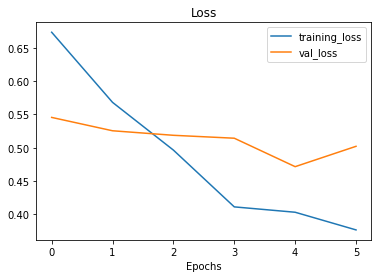

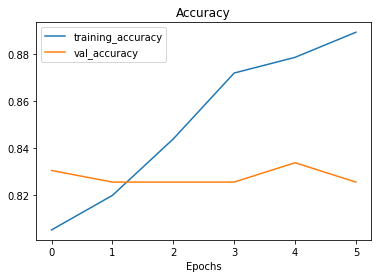

In [ ]:
#Check out the loss curves of our fine-tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curves` function works great with models which have only been fit once, however, we want something to compare one series of running `fit()` with another (e.g. before and after fine-tuning).

In [ ]:
#Let's create a funciton to compare training histories
def compare_historys(original_history, new_history, initial_epochs=5):
  """
  Compares two TensorFlow History objects.
  """
  #Get original history measurments
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  #Combine original history
  total_acc = acc+ new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = acc+ new_history.history["val_accuracy"]
  total_val_loss = loss + new_history.history["val_loss"]

  #Make plot for accuracy
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc,label="Training accuracy")
  plt.plot(total_val_acc,label="Val accuracy")
  plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label="Start Fine tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  #Make plot for loss
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,2)
  plt.plot(total_loss,label="Training loss")
  plt.plot(total_val_loss,label="Val loss")
  plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label="Start Fine tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

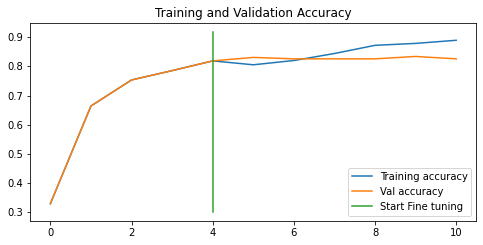

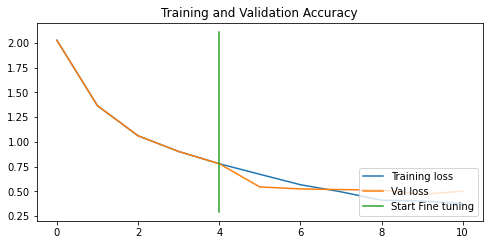

In [ ]:
compare_historys(history_10_percent_data_aug,
                 history_fine_10_percent_data_aug,
                 initial_epochs=5)

##Model 4: Fine-tuning an existing model on all of the data

In [ ]:
#Download and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2022-09-28 13:25:53--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.193.128, 173.194.194.128, 173.194.196.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   128MB/s    in 3.8s    

2022-09-28 13:25:57 (130 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
#Setup training and test dir
train_dir_all_data="10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [ ]:
#How many images are we working with?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 

In [ ]:
#Setup data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_all_data,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we've been using for previous experiments(all experiments have used the same test dataset).

Let's verify this...

In [ ]:
#Evaluate model 2 (this is the fine-tuned on 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 166s 2s/step - loss: 0.4844 - accuracy: 0.8384


[0.4843961000442505, 0.8384000062942505]

In [ ]:
results_fine_tune_10_percent

[0.4843960106372833, 0.8384000062942505]

To train a fine-tuning model(model_4) we need to revert model_2 back to its feature extraction weights.

In [ ]:
#Load weights from checkpoint, that way we can fine-tune from the same stage the 10 percent data model was fine-tuned form
model_2.load_weights(checkpoint_path)

In [ ]:
#Let's evaluate model_2 now
model_2.evaluate(test_data)

In [ ]:
#Check to see if your model_2 has been reverted back to feature extraction results
results_10_percent_data_aug

Alright, the previous steps might seem quite confusing but all we've done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (model_2) and we saved the model's weights using `ModelCheckpoint` callback.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (model_3).
3. Saved the results and training logs each time.
4. Reloaded the model from step 1 to do the same steps as step 2 except this time we're going to use all of the data(model_4).

In [ ]:
#Check which layers are tunable in the whole model
for layer_number,layer in enumerate(model_2.layers[2]):
  print(layer_number, layer.name, layer.trainable)

In [ ]:
#Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                metrics=["accuracy"])



In [ ]:
#Continue to train and fine-tune the model to our data (100% of training data)
fine_tune_epochs=10
history_fine_10_classes_full = model_2.fit(
    train_data_10_classes_full,
    epochs=10,
    validation_data=test_data,
    validation_steps=int(0.25*len(test_data)),
    initial_epoch=history_10_percent_data_aug.epoch[-1],
    callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                           experiment_name="full_10_classes_fine_tune_last_10")]
)

In [ ]:
#Let's evaluate on all of the test data
results_fine_tune_full_data=model_2.evaluate(test_data)
results_fine_tune_full_data

In [ ]:
#How did fine-tuning go with more data?
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

## Viewing our experiment data on Tensorboard

In [ ]:
#View tensorboard logs of transfer learning modelling experiments (should ~5 models)
#Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer Learning  Experiments with 10 Food 101 Classes" \
  --description "A series of different TL experiments with diff amounts of data and fine-tuning" \
  --one_shot #exits the uploader onece its finished uploading